<a id="1"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Introduction</div>

This Jupyter notebook explores various aspects of competition data using natural language processing and machine learning techniques. It encompasses several sections, including the importing of necessary packages, data exploration, analysis of question and response word count distributions, scatterplots illustrating the relationship between word counts, text analysis examining word frequencies, word clouds, and sentiment polarity. Additionally, topic analysis investigates common themes in both the training and test datasets. The notebook also has features embeddings and a PCA plot to visualize most frequent words embeddings in the text data.

**Table Of Content:**
* [Introduction](#1)
* [Importing Packages](#2)
* [Data](#3)
* [Question and Response Word Count Distributions](#4)
* [Scatterplot of Word Counts](#5)
* [Text Analysis](#6)
* [Topic Analysis](#7)
* [Embeddings](#8)

<hr>

<a id="2"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Importing Packages</div>
* [return top](#1)

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import plotly.express as px
from IPython.display import display
from bokeh.plotting import figure, output_notebook, show, output_file, save
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin
from bokeh.layouts import row, column
from bokeh.io import push_notebook
import os
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoTokenizer
import torch
from collections import defaultdict
import wandb

test = pd.read_csv("/kaggle/input/h2oai-predict-the-llm/test.csv",index_col="id")
train = pd.read_csv("/kaggle/input/h2oai-predict-the-llm/train.csv")
sample_sub = pd.read_csv("/kaggle/input/h2oai-predict-the-llm/sample_submission.csv")

<hr>

<a id="3"></a> 
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;" >Data</div>
* [return top](#1)

In [2]:
run = wandb.init(
    project="h2o-ai-predict-the-llm-kaggle-competition", 
    entity=None, 
    job_type="upload")
raw_data_at = wandb.Artifact(
        "detect_llm_raw_data", 
        type="raw_data"
    )

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
train.head()

,Question,Response,target
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3


In [6]:
test.head()

,Question,Response
id,,
0,Multiply 13 by 7.,Multiplying 13 by 7 gives a result of 64.\nThe...
1,Who were the main protagonists in the Hundred ...,The most important characters in this war incl...
2,What was the importance of the Truman Doctrine?,"The Truman Doctrine, also known as the United ..."
3,Which film features a character named Jack Ske...,The Nightmare Before Christmas
4,What are the components of the cytoskeleton?,"The cytoskeleton, which provides the framework..."


In [8]:
tbl_train = wandb.Table(data=train)
tbl_test = wandb.Table(data=test)
wandb.log({"train_df": tbl_train})
wandb.log({"test_df": tbl_test})
raw_data_at.add(tbl_train, "train_df")
raw_data_at.add(tbl_test, "test_df")

<ManifestEntry ref: wandb-client-artifact://pvr82yxf2jsmkroyvn6h39f0lk559yeyefbom3raarmuveheeoto0i3pu7xaa0cf99ot4et9c7cbd48b9yunw9hi5p5uiblzco6g0lxmqdv79nxja4xzfpgf1tsma0sb/test_df.table.json/test_df.table.json>

In [10]:
print("-"*20+"Train"+"-"*20)
train_q_stat = pd.DataFrame(train.Question.describe())
train_r_stat = pd.DataFrame(train.Response.describe())
test_q_stat = pd.DataFrame(test.Question.describe())
test_r_stat = pd.DataFrame(test.Response.describe())
display(train_q_stat)
print("")
display(train_r_stat)
print("")
print("-"*20+"Test"+"-"*20)
display(test_q_stat)
print("")
display(test_r_stat)

tbl_train_q_stat = wandb.Table(data=train_q_stat.astype("str"))
tbl_train_r_stat = wandb.Table(data=train_r_stat.astype("str"))
tbl_test_q_stat = wandb.Table(data=test_q_stat.astype("str"))
tbl_test_r_stat = wandb.Table(data=test_r_stat.astype("str"))
wandb.log({"train_q_stat": tbl_train_q_stat})
wandb.log({"train_r_stat": tbl_train_r_stat})
wandb.log({"test_q_stat": tbl_test_q_stat})
wandb.log({"test_r_stat": tbl_test_r_stat})

--------------------Train--------------------


,Question
count,3976
unique,568
top,Explain the concept of coevolution.
freq,7


,Response
count,3969
unique,3968
top,__________
freq,2



--------------------Test--------------------


,Question
count,1001
unique,143
top,Multiply 13 by 7.
freq,7


,Response
count,999
unique,999
top,Multiplying 13 by 7 gives a result of 64.\nThe...
freq,1


In [11]:
train.fillna("*",inplace=True)
test.fillna("*",inplace=True)
def count_string(x):
    return len(x.split())
train["word_count_q"]= train.Question.apply(count_string)
test["word_count_q"]=test.Question.apply(count_string)
train["word_count_r"]= train.Response.apply(count_string)
test["word_count_r"]=test.Response.apply(count_string)

<hr>

<a id="4"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Question and Response Word Count Distributions</div>
* [return top](#1)

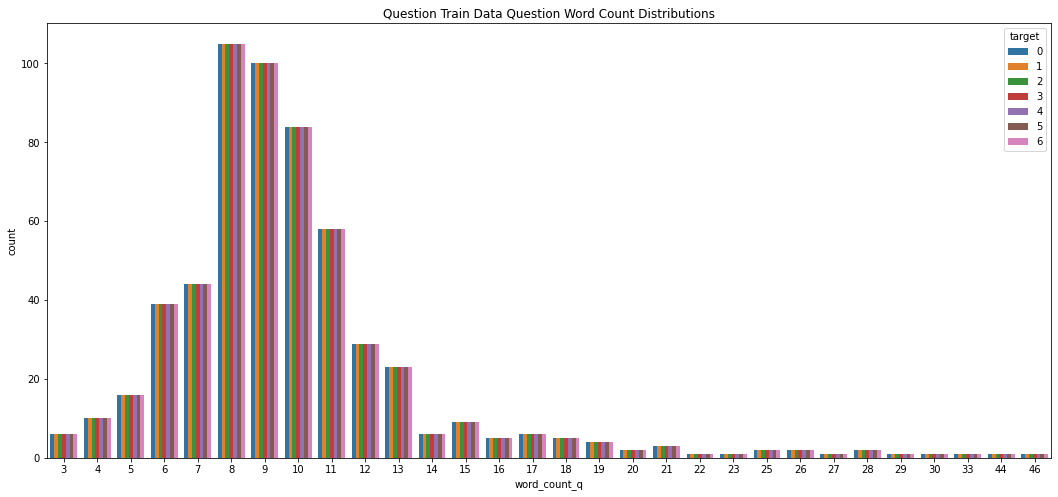

In [12]:
plt.figure(figsize=(18,8))
sns.countplot(data=train, x="word_count_q",hue="target")
plt.title("Question Train Data Question Word Count Distributions");
plt.savefig("0-question-train-data-question-word-count-distributions.png", format="png")
plt.show()

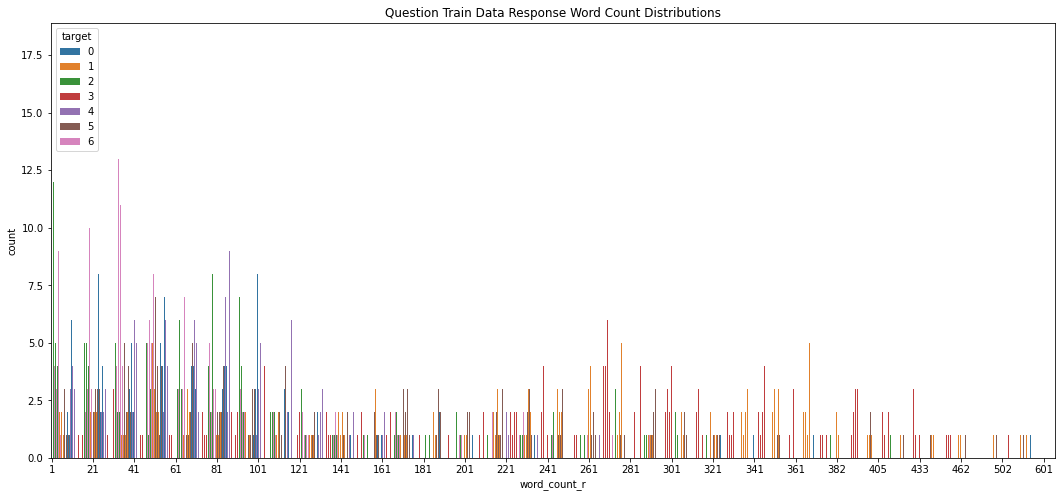

In [13]:
plt.figure(figsize=(18,8))
sns.countplot(data=train, x="word_count_r",hue="target")
plt.xticks(list(range(0,500,20)));
plt.title("Question Train Data Response Word Count Distributions");
plt.savefig("1-question-train-data-response-word-count-distributions.png", format="png")
plt.show()

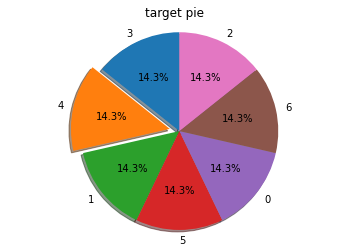

3    568
4    568
1    568
5    568
0    568
6    568
2    568
Name: target, dtype: int64


In [14]:
def pieplot(df, col, title, explodeplace=0):
    """
    Create a pie chart from a DataFrame column.

    Args:
        df (DataFrame): The DataFrame containing the data.
        col (str): The name of the column to plot.
        title (str): Title for the pie chart.
        explodeplace (int): Index of the segment to explode (default: 0).

    Returns:
        None
    """
    value_counts = df[col].value_counts()
    explode = np.zeros(len(value_counts))
    explode[explodeplace] = 0.1

    plt.pie(value_counts, explode=explode, labels=value_counts.index, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.title(title)
    plt.show()
    print(value_counts)
pieplot(train,"target","target pie",explodeplace=1)

<hr>

<a id="5"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Scatterplot of Word Counts</div>
* [return top](#1)

This scatterplot illustrates the relationship between word counts in questions and responses. Each data point represents a specific instance in the dataset. The points are color-coded based on the 'target' variable, and hovering over a point reveals additional information about the data point, including its index, question text, and response text.
The x-axis represents the word count in the question, and the y-axis represents the word count in the response.

In [15]:
train["char_count_q"] = train.Question.apply(lambda x: len(x))
train["char_count_r"] = train.Response.apply(lambda x: len(x))
# Shorten the text in 'Question' and 'Response' columns
train["Question_short"] = train["Question"].apply(lambda x: " ".join(x.split()[:10]))
train["Response_short"] = train["Response"].apply(lambda x: " ".join(x.split()[:10]))
train["idx"] = range(len(train))
# Create a ColumnDataSource from the DataFrame
source = ColumnDataSource(train)



# Create a color mapper for the 'target' column
mapper = linear_cmap(field_name='target', palette=["red", "green", "blue", "black", "orange", "purple", "slategray"], low=0, high=6)

# Create the figure
p = figure(title="Scatterplot of Word Counts", x_axis_label="Word Count in Question", y_axis_label="Word Count in Response",
           plot_width=900, plot_height=600)

# Create a scatter plot
scatter = p.scatter(x="word_count_q", y="word_count_r", source=source, size=8, color=mapper, legend_field='target')
# Add hover tool to display additional information
hover = HoverTool()
hover.tooltips = [("Index", "@idx"), ("Question (Short)", "@Question_short"), ("Response (Short)", "@Response_short"),("Target", "@target")]
p.add_tools(hover);
# Show the plot
# output_notebook()
# show(p, notebook_handle=True)
# Specify the output file
output_file("scatterplot.html")

# Save the plot as an HTML file
save(p)

# Display the HTML file in Jupyter
from IPython.display import IFrame
IFrame(src='scatterplot.html', width=950, height=650)

In [16]:
source = ColumnDataSource(train)

# Create a color mapper for the 'target' column
mapper = linear_cmap(field_name='target', palette=["red", "green", "blue", "black", "orange", "purple", "slategray"], low=0, high=6)

# Create the figure
p = figure(title="Scatterplot of Char Counts", x_axis_label="Char Count in Question", y_axis_label="Char Count in Response",
           plot_width=900, plot_height=600)
# Create a scatter plot
scatter = p.scatter(x="char_count_q", y="char_count_r", source=source, size=8, color=mapper, legend_field='target')
# Add hover tool to display additional information
hover = HoverTool()
hover.tooltips = [("Index", "@idx"), ("Question (Short)", "@Question_short"), ("Response (Short)", "@Response_short"),("Target", "@target")]
p.add_tools(hover);
# Show the plot
# output_notebook()
# show(p, notebook_handle=True)

output_file("scatterplot2.html")

# Save the plot as an HTML file
save(p)

# Display the HTML file in Jupyter
from IPython.display import IFrame
IFrame(src='scatterplot2.html', width=950, height=650)

In [17]:
"LLM Model's Mean Output Words Count".lower().replace(" ","-")

"llm-model's-mean-output-words-count"

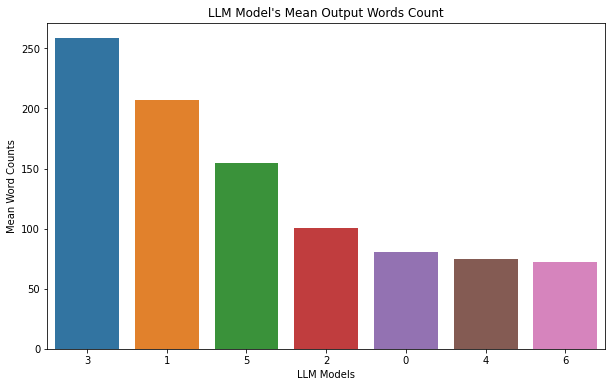

In [18]:
aggregation = train.groupby("target")["word_count_r"].mean()
plt.figure(figsize=(10,6))
sns.barplot(x=aggregation.index,y=aggregation.values,
           order=aggregation.sort_values(ascending=False).index)
plt.ylabel("Mean Word Counts")
plt.xlabel("LLM Models")
plt.title("LLM Model's Mean Output Words Count")
plt.savefig("2-llm-model's-mean-output-words-count.png", format="png")
plt.show();

In [19]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(set(stopwords.words('english')));

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<hr>

<a id="6"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Text Analysis</div>
* [return top](#1)

Here is basic text analysis, including word count, character count, average word length, and sentiment analysis. It also visualizes the most common words and sentiment distribution.

Basic Summary:
                                   Question
count                                  3976
unique                                  568
top     Explain the concept of coevolution.
freq                                      7
Most Common Words:
what: 1603 times
who: 476 times
how: 329 times
explain: 322 times
describe: 301 times
can: 287 times
i: 266 times
concept: 231 times
could: 203 times
cause: 168 times


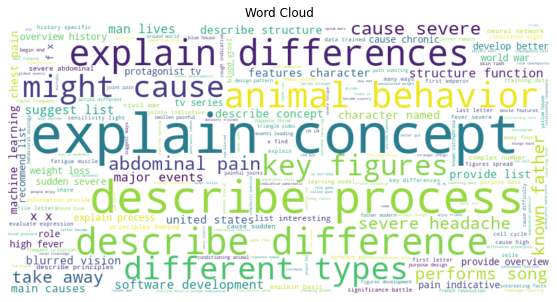

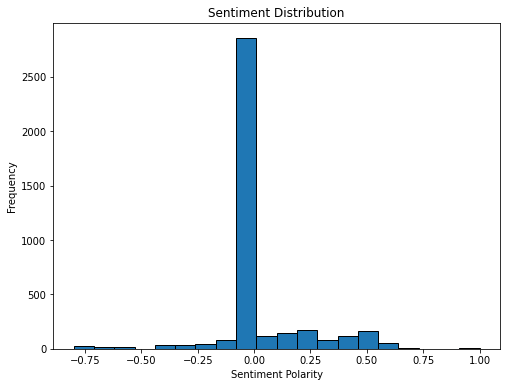


Basic Summary:
       Response
count      3976
unique     3969
top           *
freq          7
Most Common Words:
the: 4557 times
this: 2545 times
data: 1859 times
it: 1535 times
a: 1266 times
i: 1252 times
also: 1177 times
in: 1154 times
process: 1075 times
like: 1041 times


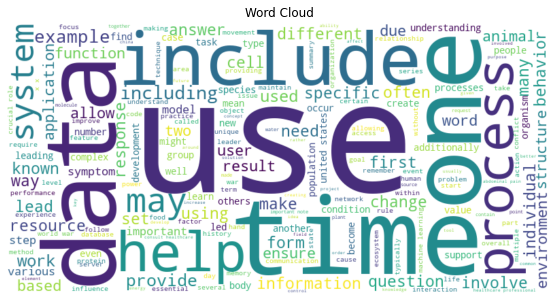

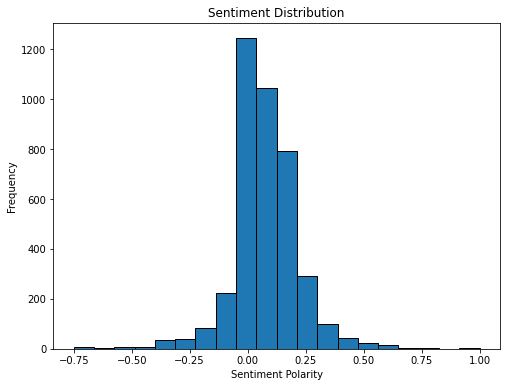

,Question,Response,target,word_count_q,word_count_r,char_count_q,char_count_r,Question_short,Response_short,idx
196,Can you provide a guide to starting a meditati...,*,6,10,1,58,1,Can you provide a guide to starting a meditati...,*,196
339,How do you manage to keep information concise ...,*,1,14,1,93,1,How do you manage to keep information concise ...,*,339
401,What safeguards are in place to prevent misuse...,*,0,13,1,81,1,What safeguards are in place to prevent misuse...,*,401
798,How do you ensure the safety of the informatio...,*,1,11,1,60,1,How do you ensure the safety of the informatio...,*,798
819,Who were the key figures in the spread of Budd...,* Siddhartha Gautama (Buddha): Founder of Budd...,1,10,186,51,1209,Who were the key figures in the spread of Budd...,* Siddhartha Gautama (Buddha): Founder of Budd...,819
1081,What might cause severe abdominal pain and blo...,"* Excessive intake of alcohol, tobacco, and ce...",5,9,48,59,312,What might cause severe abdominal pain and blo...,"* Excessive intake of alcohol, tobacco, and ce...",1081
1931,What word is spelled incorrectly in every sing...,"*Note that this riddle doesn't make sense, as ...",1,9,40,60,256,What word is spelled incorrectly in every sing...,"*Note that this riddle doesn't make sense, as ...",1931
2141,What are some tips for staying motivated when ...,* Identify your passion and purpose with the w...,5,12,77,67,450,What are some tips for staying motivated when ...,* Identify your passion and purpose with the w...,2141
2279,How can I improve my memory and recall abilities?,*,1,9,1,49,1,How can I improve my memory and recall abilities?,*,2279
2725,"Tires a horse, worries a man. Tell me this rid...",*,0,13,1,61,1,"Tires a horse, worries a man. Tell me this riddle",*,2725


,Question,Response,word_count_q,word_count_r
id,,,,
273,Which film features a character named Jack Ske...,*The Nightmare Before Christmas (1993)*\nJack ...,8,105
446,I have seven letters and am something you eat....,*,49,1
969,What was the impact of the fall of Constantino...,*,11,1
971,Can you create a short story based on a specif...,"**Title:** ""Melody's Mysterious Symphony""\n\n*...",11,417


In [20]:
def preprocess_text(text):
        words = word_tokenize(text)
        words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
        return words
def text_analysis(df_,col = 'Response',df_name_fig = "train"):
    df = df_.copy()

    # Basic summary of the text data
    print("Basic Summary:")
    print(df[[col]].describe())

    # Word Count
    df['Word Count'] = df[col].apply(lambda x: len(str(x).split()))

    # Character Count
    df['Character Count'] = df[col].apply(len)

    # Average Word Length
    df['Avg Word Length'] = df.apply(lambda row: row['Character Count'] / row['Word Count'] if row['Word Count']!=0 else row['Character Count'] / 1 , axis=1)

    # Most Common Words
    
    clean_words = preprocess_text(" ".join(df[col].to_list()))
    
    all_words = ' '.join(clean_words)
        
    word_freq = Counter(all_words.split())
    most_common_words = word_freq.most_common(10)
    print("Most Common Words:")
    for word, freq in most_common_words:
        print(f"{word}: {freq} times")
    most_common_words_df = pd.DataFrame(most_common_words,columns=["word","freq"])
    # Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud")
    plt.savefig(f"3-{col}-{df_name_fig}-wordcloud.png", format="png")
    plt.show()

    # Sentiment Analysis
    df['Sentiment'] = df[col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    # Visualize Sentiment Distribution
    plt.figure(figsize=(8, 6))
    df['Sentiment'].plot(kind='hist', bins=20, edgecolor='k')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Frequency")
    plt.savefig(f"3-{col}-{df_name_fig}-sentiment-polarity.png", format="png")
    plt.show()
    print("")
    return most_common_words_df
most_common_words_df_q_tr = text_analysis(train,col = 'Question',df_name_fig = "train")


most_common_words_df_r_tr = text_analysis(train,col = 'Response',df_name_fig = "train")
display(train[(train['Question'].apply(lambda text : text.startswith("*")) | 
              (train['Response'].apply(lambda text : text.startswith("*"))))])
display(test[(test['Question'].apply(lambda text : text.startswith("*"))) | 
            (test['Response'].apply(lambda text : text.startswith("*")))])

The provided summaries appear to be describing statistics and common words for two different types of data: 'Question' and 'Response'. There seem to be seven identical questions across seven different LLM (Language Model) models, as indicated by the "top" question with a frequency of 7. The summaries can be described as follows:

**For 'Question':**
- There are a total of 3,976 questions.
- There are 568 unique questions.
- The most frequently occurring question shown as "Explain the concept of coevolution."
- We have seven same questions for seven different LLM (Language Model) models. 
- For train 3976 / 7 = 568 unique Questions
- For test 1001 / 7 = 143 unique Questions



**Most Common Words in 'Question':**
- The word "what" occurs 1,603 times.
- Other common words in the questions include "who," "how," "explain," "describe," "can," "I," "concept," "could," and "cause."

**For 'Response':**
- There are a total of 3,976 responses.
- There are 3,969 unique responses.
- The most frequent response is empty (blank).
- The empty response appears 7 times.
- Train empty indexes [196, 339, 401, 798, 2279, 2725, 3046]
- Test empty indexes [446, 969]

**Most Common Words in 'Response':**
- The word "the" occurs 4,557 times.
- Other common words in the responses include "this," "data," "it," "a," "I," "also," "in," "process," and "like."

These summaries provide insights into the data, including data count, uniqueness, and the most common words found in the 'Question' and 'Response' columns. It appears that the 'Response' data contains empty responses, and the 'Question' data focuses on common introductory words and phrases used in questions.

<hr>

<a id="7"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Topic Analysis</div>
* [return top](#1)

The code performs topic analysis on text data from two different columns: 'Question' and 'Response'. The process involves the following steps:
1. **Text Preprocessing:** Preprocesses the text data to prepare it for topic modeling.
2. **Tokenization:** Tokenizes the text data, creating a tokenized version of the 'Response' column.
3. **Topic Modeling:** Applies Latent Dirichlet Allocation (LDA) to discover topics in the text data. It identifies three topics based on the content of the text.
4. **Displaying Topics:** Prints the topics discovered by LDA, including the most significant words for each topic.
5. **Assigning Topics:** Assigns topics to each response, allowing you to see which topic each response is associated with.
6. **Displaying Assigned Topics:** Prints the topics assigned to each 'Question' and 'Response'.
7. **Topic Suggestion:** The "Topic Suggestion" section provides insights into potential categories or themes for each topic. These suggestions can help categorize the data effectively.

In [21]:
train["question_and_response"] = train.Question + " " +train.Response
test["question_and_response"] = test.Question + " " +test.Response

In [22]:
np.random.seed(1)
def topic_analysis(df_,col = 'Response'):
    df = df_.copy()
    # Text preprocessing

    # Apply preprocessing to the "Response" column
    df[f'Tokenized_{col}'] = df[col].apply(preprocess_text)

    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(df[f'Tokenized_{col}'])
    corpus = [dictionary.doc2bow(text) for text in df[f'Tokenized_{col}']]

    # Perform LDA topic modeling
    lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15,random_state=1)

    # Print the topics
    print("")
    print(f"LDA Topics - {col}:")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx}: {topic}")

    # To assign topics to each response, you can use the following:
    df['Topic'] = df[f'Tokenized_{col}'].apply(lambda text: lda_model[dictionary.doc2bow(text)][0][0])

    # Print the topics assigned to each response
    print(f"Topics Assigned to {col}:")
    print(df[[col, 'Topic']])
    print("")
print("Train Data Topic Analysis")
topic_analysis(train,col = 'question_and_response')

Train Data Topic Analysis

LDA Topics - question_and_response:
Topic 0: 0.033*"data" + 0.009*"information" + 0.009*"the" + 0.008*"model" + 0.008*"learning" + 0.007*"used" + 0.006*"this" + 0.006*"process" + 0.005*"ai" + 0.005*"language"
Topic 1: 0.017*"i" + 0.008*"help" + 0.007*"this" + 0.006*"answer" + 0.006*"what" + 0.006*"time" + 0.006*"use" + 0.005*"question" + 0.005*"skills" + 0.005*"make"
Topic 2: 0.015*"the" + 0.012*"x" + 0.010*"this" + 0.010*"cell" + 0.009*"process" + 0.008*"cells" + 0.007*"dna" + 0.007*"behavior" + 0.006*"animals" + 0.006*"in"
Topic 3: 0.020*"the" + 0.008*"cause" + 0.007*"war" + 0.007*"symptoms" + 0.007*"pain" + 0.006*"it" + 0.006*"world" + 0.005*"what" + 0.005*"this" + 0.005*"also"
Topic 4: 0.014*"the" + 0.008*"this" + 0.006*"species" + 0.006*"one" + 0.006*"it" + 0.006*"what" + 0.005*"code" + 0.005*"in" + 0.005*"system" + 0.005*"different"
Topics Assigned to question_and_response:
                                  question_and_response  Topic
0     Explain the

**Topic 0:**
- Words: "data," "information," "the," "model," "learning," "used," "this," "process," "ai," "language"
- Category: **Machine Learning and Data Analysis** - This topic appears to be related to machine learning, data analysis, and artificial intelligence, focusing on data, information, models, and learning.

**Topic 1:**
- Words: "i," "help," "this," "answer," "what," "time," "use," "question," "skills," "make"
- Category: **Personal Assistance and Problem-Solving** - This topic seems to revolve around personal assistance and problem-solving, where "i," "help," and "answer" suggest assistance and addressing questions or challenges.

**Topic 2:**
- Words: "the," "x," "this," "cell," "process," "cells," "dna," "behavior," "animals," "in"
- Category: **Biology and Cellular Processes** - This topic appears to be related to biology and cellular processes, with words like "cell," "process," "dna," and "animals" indicating a focus on biological subjects.

**Topic 3:**
- Words: "the," "cause," "war," "symptoms," "pain," "it," "world," "what," "this," "also"
- Category: **Historical and Health-related Topics** - This topic suggests a mix of historical and health-related discussions, with mentions of "war," "symptoms," and "pain."

**Topic 4:**
- Words: "the," "this," "species," "one," "it," "what," "code," "in," "system," "different"
- Category: **Species and Systems** - This topic may relate to discussions about species, systems, and differences between various elements or entities.

These are the identified topics from the combined questions and responses. Each topic represents a distinct theme or category, and the assigned category is based on the prominent words within each topic. The model seems to capture a range of topics, including machine learning, personal assistance, biology, history, and systems.

In [23]:
print("Test Data Topic Analysis")
np.random.seed(1)
topic_analysis(test,col = 'question_and_response')

Test Data Topic Analysis

LDA Topics - question_and_response:
Topic 0: 0.011*"dna" + 0.011*"the" + 0.007*"testing" + 0.007*"information" + 0.007*"factory" + 0.007*"model" + 0.006*"i" + 0.006*"rna" + 0.005*"this" + 0.005*"specific"
Topic 1: 0.022*"the" + 0.011*"data" + 0.010*"war" + 0.007*"this" + 0.007*"learning" + 0.006*"world" + 0.006*"it" + 0.005*"what" + 0.005*"states" + 0.004*"one"
Topic 2: 0.009*"this" + 0.008*"data" + 0.007*"the" + 0.007*"system" + 0.006*"process" + 0.005*"encryption" + 0.005*"use" + 0.005*"key" + 0.005*"set" + 0.005*"code"
Topic 3: 0.012*"the" + 0.008*"symptoms" + 0.007*"pain" + 0.007*"cells" + 0.006*"cause" + 0.005*"dance" + 0.005*"what" + 0.005*"disease" + 0.005*"also" + 0.005*"this"
Topic 4: 0.009*"time" + 0.007*"help" + 0.007*"even" + 0.007*"i" + 0.007*"this" + 0.005*"the" + 0.005*"a" + 0.005*"like" + 0.004*"two" + 0.004*"what"
Topics Assigned to question_and_response:
                                  question_and_response  Topic
id                        

When comparing the content of topics between the train and test data, we can observe that there are some similarities and differences.
<hr>

* Train Data:
 - Topic 0: Appears to be related to data, information, and models used in AI and machine learning.
 - Topic 1: Relates to personal assistance and problem-solving, with words like "i," "help," and "answer."
 - Topic 2: Focuses on biology and cellular processes, with terms like "cell," "process," and "dna."
 - Topic 3: Contains elements of history and health-related discussions with words such as "war," "symptoms," and "pain."
 - Topic 4: Appears to discuss species, systems, and differences between elements or entities.

<hr>

* Test Data:
 - Topic 0: Discusses DNA, testing, and models, which is somewhat similar to Topic 2 in the train data.
 - Topic 1: Covers topics related to data, war, and learning, which shares similarities with Topic 3 in the train data.
 - Topic 2: Appears to be related to data and systems, with some overlap with Topic 0 in the train data.
 - Topic 3: Discusses symptoms, pain, and cells, which aligns with Topic 3 in the train data.
 - Topic 4: Contains terms like "time," "help," and "i," which has some resemblance to Topic 1 in the train data.
 
<hr>

Train's Topic 4 seems like not comman in test data.

<hr>

<a id="8"></a>
# <div style="border: 2px solid #555; color:black; border-radius: 10px; background-color: #0074D9; padding: 10px; font-size: 20px; text-align: center;">Embeddings</div>
* [return top](#1)

This code preprocesses text data, constructs a word corpus, selects the top N words, computes their BERT embeddings, and visualizes them via PCA with scatter chart.

In [24]:
df = train.copy()
col = "Response"
# Text preprocessing

# Apply preprocessing to the "Response" column
df[f'Tokenized_{col}'] = df[col].apply(preprocess_text)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df[f'Tokenized_{col}'])
corpus = [dictionary.doc2bow(text) for text in df[f'Tokenized_{col}']]

top_num_word = 1000
# Count word frequencies in the corpus
word_freq = defaultdict(int)

# Concatenate all tokenized texts into one list of words
all_words = [word for text in df[f'Tokenized_{col}'] for word in text]

# Count the frequencies of each word
for word in all_words:
    word_freq[word] += 1

# Sort words by frequency in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)

# Take the top_num_word most common words
locals()["top_{top_num_word}_words"] = [word for word, freq in sorted_word_freq[:top_num_word]]
# print(locals()["top_{top_num_word}_words"])

# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


words_to_visualize = locals()["top_{top_num_word}_words"]
word_tokens = tokenizer(words_to_visualize, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    word_embeddings = model(**word_tokens);

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
word_embeddings_pca = pca.fit_transform(word_embeddings.last_hidden_state[:, 0, :])

# Data
x_values = word_embeddings_pca[:, 0]
y_values = word_embeddings_pca[:, 1]
labels = words_to_visualize

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(x=x_values, y=y_values, label=labels))

# Create the scatter plot
p = figure(title=f"Word Embeddings Visualization of Top_{top_num_word}_Words", plot_width=800, plot_height=600)

p.circle('x', 'y', size=10, source=source, fill_alpha=0.6, line_color='black', fill_color='blue')

# Add hover tooltips
hover = HoverTool()
hover.tooltips = [("Word", "@label")]
p.add_tools(hover)
p.xaxis.axis_label = "PCA Dimension 1"
p.yaxis.axis_label = "PCA Dimension 2"

# Show the plot
output_file("pca_embed.html")
save(p)

# Display the HTML file in Jupyter
from IPython.display import IFrame
IFrame(src='pca_embed.html', width=950, height=650)

In [26]:
tbl_most_common_words_df_q_tr = wandb.Table(data=most_common_words_df_q_tr)
tbl_most_common_words_df_r_tr = wandb.Table(data=most_common_words_df_r_tr)
tbl_train_end = wandb.Table(data=train)
wandb.log({"most_common_words_df_q_tr_df": tbl_most_common_words_df_q_tr})
wandb.log({"most_common_words_df_r_tr_df": tbl_most_common_words_df_r_tr})
wandb.log({"train_end_df": tbl_train_end})
raw_data_at.add(tbl_train_end, "train_df_end_eda")


<ManifestEntry ref: wandb-client-artifact://agbvnksdt8cgt4uvxlk4g1gep6aocb4utobwjp061zbg9x7qr1zbmydoif4r4d0wxjtmcyeejk0vq0kjxjlsq98lbzhtvmbcg1fo1u1crewx9j3ahvyxjcnnldd6cvyy/train_end_df.table.json/train_df_end_eda.table.json>

In [27]:
for i,png in enumerate([filename for filename in os.listdir() if filename.endswith('.png')]):
    locals()[f"png_{i}_image"] = wandb.Image(data_or_path=png)
    wandb.log({f"png_{i}": locals()[f"png_{i}_image"]})

In [28]:
for i,html in enumerate([filename for filename in os.listdir() if filename.endswith('.html')]):
    name = html.split(".")[0]
    locals()[f"html_{i}_{name}"] = wandb.Html(html)
    wandb.log({f"html_{i}_{name}" :  locals()[f"html_{i}_{name}"]})

In [29]:
run.log_artifact(raw_data_at)

In [30]:
run.finish()